![](cover.png)

# 生成式對抗網路 - GAN

## 介紹

之前介紹的CNN和RNN都是屬於監督式的分類任務，但是現實我們想做到的事更多也更宏大

譬如：讓電腦學會寫字，讓電腦學會填補圖畫之類

但是這種任務都是屬於無中生有的事，我們之前所教的單純分類任務是做不到的

於是就有人提出了GAN(Generative Adversarial Network)

## GAN介紹

GAN一個重點就是Generative(生成)，他試圖讓電腦開始有創作的可能性

第二個重點就是Adversarial(對抗)，因為創作，一定不可能是標注好答案的(監督式)

那也不可能完全無憑藉(非監督式)的創造

所以他使用的方法是半監督式，藉由環境的反饋來決定一個創作好不好

![](gan.png)

上圖是整個GAN的架構圖

其實概念非常的簡單

我們會有一個正常的分類器，來當作鑑賞家，這個鑑賞家(Discriminator)只要學會分類兩件事情，真(我們真實的mnist資料)和偽(我們隨手創造出來的數字)

接著我們會有一個反向(神經元越來越多)的深度網路，來當作創作家，這個創作家(Generator)會依據神經元的權重來創造數字

接著我們進行以下的步驟，每個batch都要這麼進行

1. 把真實資料的一個batch標示為真丟給鑑賞家，也讓創作家創作一個batch標示為鑑賞家，並且訓練，讓鑑賞家學會真假
2. 讓創作家再創作一個batch，這時候開始訓練創作家，讓創作家的作品接近鑑賞家現在的真

不斷的進行這個步驟，創作家和鑑賞家的水品都會提升，來到最後，創作家就可以創作幾可亂真的作品了

## 變種GAN

除了最基本的GAN，還有許多不同的GAN，譬如CGAN(Conditional Generative Adversarial Net)，把機率換成了條件機率，就可以指定創作某一類的數字

![](cgan.png)


## 變種GAN參考

https://github.com/eriklindernoren/Keras-GAN

## ✔ Step1. 資料預處理

這裡我們選用內建的mnist手寫數字資料庫來，mnist提供共70000筆手寫數字，而且用keras讀取的時候會直接幫你分成訓練和測試兩份資料

In [1]:
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers import Embedding, BatchNormalization
from keras.datasets import mnist
import numpy as np
%matplotlib inline
# 我們會使用到一些內建的資料庫, MAC需要加入以下兩行, 才不會把對方的ssl憑證視為無效
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

Using TensorFlow backend.


In [2]:
# 回傳值: ((訓練特徵, 訓練目標), (測試特徵, 測試目標))
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
from keras.utils import np_utils
# reshape讓他從 32 * 32變成 784 * 1的一維陣列
# 讓我們標準化到-1~1區間
x_train_shaped = (x_train.reshape(60000, 784).astype("float32") - 127.5)/127.5
x_test_shaped = (x_test.reshape(10000, 784).astype("float32") - 127.5)/127.5

## ✔ Step2. 建立創作家

我們做一個跟我們以前反向的深度網路，神經元隨著層數越來越大，最後的神經元數目要等於你要創作的圖片的維度(28 x 28)

這裡大家在activation因為不是要二分機率，所以還蠻喜歡有極正和極負的輸出，所以還蠻常使用tanh當作激活函數(-1 ~ 1)，不過你也可以使用sigmoid當你的激活函數

### BatchNormalization

這裡我們使用了一個在原始GAN論文裡沒使用的技巧

因為GAN的Generator和Discriminator都極其的脆弱

1. 因為是一個反向的神經元擴大，所以可以想見一點影響都會被擴大   
2. 你會發現創作的圖片很容易讓鑑賞家走到relu的『死亡區』，就是為0，而且斜率為0的區域，一旦來到這區域，代表梯度更新為0，沒機會從死亡區回來，這時候我們就說這神經元已經死掉了


這裡我們想起了一件事，我們再傳入我們的圖片的時候，通常會喜歡做一次Normalization到0~1，優點是可以好好配合Keras隨機的Weights，不會隨意的亂走

但第二層以後都是神經網路算出來的值，那我們現在可不可以也採納這個概念呢？讓第二層以後的所有算出值也做出標準化呢？

可以的，而且由於我們是批次(batch)的訓練，所以我們也希望可以直接對整個batch做一次Normalization就好

![](bn.png)

上面是Batch Normalization的公式

前三行很簡單，就是普通的標準化，平移到均值為0的位置，縮放成標準差爲1

整個精華在第四行，因為我們的特徵可能本來就不該均值0和標準差1啊，所以他加了個縮放參數在這裡(Gamma和Belta)

而且讓神經網路自己學習每一層的縮放參數是多少！

經過這美美的Batch Normalization，我們達成兩個優點

1. 每一層都有經過適度的縮放和平移，可以很好的配合初始的權重
2. 因為經過縮放和平移，所以不會整組落入relu死亡區，就算這次落入死亡區，下一次還有機會經過BN被拉回來

記得在GAN的創作家每一層，我們都可以放上Batch Normalization這個技巧！會讓你的結果變得比較美！

In [5]:
random_dim = 100
generator = Sequential()
generator.add(Dense(256, input_dim=random_dim, 
                    activation='relu', 
                    kernel_initializer="random_normal"))
generator.add(BatchNormalization())
generator.add(Dense(512, activation='relu', 
                    kernel_initializer="random_normal"))
generator.add(BatchNormalization())
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer="adam")
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               402192    
Total params: 562,704
Trainable params: 561,168
Non-trainable params: 1,536
_________________________________________________________________


## ✔ Step3. 建立鑑賞家

一個專門來負責看揪出創作家創造的假作品的鑑賞家，我使用最簡單的MLP當作我們鑑賞家

In [6]:
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, 
                        activation='relu', 
                        kernel_initializer="random_normal"))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(512, activation='relu', 
                        kernel_initializer="random_normal"))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(256, activation='relu',
                        kernel_initializer="random_normal"))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer="adam")
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total para

## ✔ Step4. 組合網路

這裡為了方便訓練創作家，把它們組合在一起

那由於只是訓練創作家，所以我們要把鑑賞家的參數固定住，直接設置trainable = False即可

不過要在compile前就設定，compile完了就不會改變

所以我們只有在組合網路有將鑑賞家的參數固定(可以看Non-trainable params確定)

In [7]:
discriminator.trainable = False
gan_input = Input(shape=(random_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer="adam")
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               562704    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,022,929
Trainable params: 561,168
Non-trainable params: 1,461,761
_________________________________________________________________


In [8]:
batch_size = 200
epoch_count = 10
d_loss_list = []
g_loss_list = []
for epoch in range(0, epoch_count):
    for batch_count in range(0, 300):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train_shaped[idx]

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        # 步驟0:讓創作家製造出fake image
        noise = np.random.normal(0, 1, (batch_size, random_dim))
        gen_imgs = generator.predict(noise)

        discriminator.trainable = True
        # 步驟1:讓鑑賞家鑑賞對的image
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        # 步驟2:讓鑑賞家鑑賞錯的image
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = (d_loss_real + d_loss_fake) / 2

        discriminator.trainable = False
        noise = np.random.normal(0, 1, (batch_size, random_dim))
        # 步驟3:訓練創作家的創作能力
        g_loss = gan.train_on_batch(noise, valid)
    dash = "-" * 15
    print(dash, "epoch", epoch, dash)
    print("Discriminator loss:", d_loss)
    print("Generator loss:", g_loss)
    d_loss_list.append(d_loss)
    g_loss_list.append(g_loss)


--------------- epoch 0 ---------------
Discriminator loss: 0.1319003701210022
Generator loss: 8.2713375
--------------- epoch 1 ---------------
Discriminator loss: 0.1373519003391266
Generator loss: 5.532821
--------------- epoch 2 ---------------
Discriminator loss: 0.41682881116867065
Generator loss: 2.3718922
--------------- epoch 3 ---------------
Discriminator loss: 0.462246835231781
Generator loss: 1.5258994
--------------- epoch 4 ---------------
Discriminator loss: 0.5252199769020081
Generator loss: 1.3568485
--------------- epoch 5 ---------------
Discriminator loss: 0.49116039276123047
Generator loss: 1.2497867
--------------- epoch 6 ---------------
Discriminator loss: 0.534600019454956
Generator loss: 1.126162
--------------- epoch 7 ---------------
Discriminator loss: 0.554734468460083
Generator loss: 1.0554607
--------------- epoch 8 ---------------
Discriminator loss: 0.5893127918243408
Generator loss: 1.1031088
--------------- epoch 9 ---------------
Discriminator loss

## ✔ Step4. 訓練結果

你發現在鑑賞家的逼迫下，我們訓練出來的創作家創造的數字已經有模有樣了，有些數字已經看起來非常的真實了！

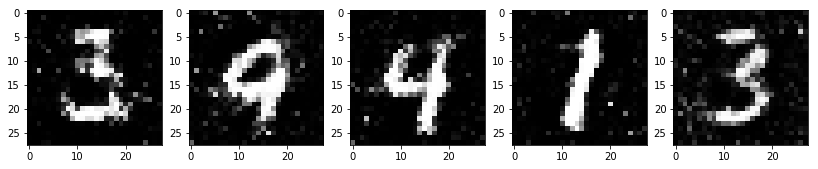

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
examples = 5
noise = np.random.normal(0, 1, (examples, random_dim))
gen_imgs = generator.predict(noise)

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5
gen_imgs = gen_imgs.reshape(examples, 28, 28)
plt.figure(figsize = (14, 14))
for i in range(0, examples):
    plt.subplot(1, examples, i + 1)
    plt.imshow(gen_imgs[i], cmap='gray')
